In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers evaluate datasets requests pandas scikit-learn fair-esm wandb graph-part python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 116.4 MB/s eta 0:00:00


### Homology Partitioning

In [ ]:
# Install mamba and setup conda environment in Google Colab
!pip install -q condacolab
import condacolab
condacolab.install()

# Create a new code cell and run these commands
!mamba install -y -c conda-forge mamba
!mamba create -n myenv -y
!mamba init bash
!source ~/.bashrc
!conda activate myenv
!mamba install -y -c bioconda emboss mmseqs2

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:07
🔁 Restarting kernel...

Looking for: ['mamba']

[+] 0.0s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   3%
conda-forge/noarch     2%[+] 0.3s
conda-forge/linux-64  16%
conda-forge/noarch    20%[+] 0.4s
conda-forge/linux-64  16%
conda-forge/noarch    44%[+] 0.5s
conda-forge/linux-64  18%
conda-forge/noarch    54%[+] 0.6s
conda-forge/linux-64  25%
conda-forge/noarch    59%[+] 0.7s
conda-forge/linux-64  28%
conda-forge/noarch    87%conda-forge/noarch                                
[+] 0.8s
conda-forge/linux-64  41%[+] 0.9s
conda-forge/linux-64  49%[+] 1.0s
conda-forge/linux-64  71%[+] 1.1s
conda-forge/linux-64  83%[+] 1.2s
conda-forge/linux-64  95%[+] 1.3s
conda-forge/linux-64  95%conda

In [ ]:
from graph_part import train_test_validation_split, stratified_k_fold
from sys import exit
import condacolab

In [ ]:
def filter_df(df, n):
  df['sequence'] = df['sequence'].str.upper()
  df = df.sort_values(by='viral_selection', ascending=False)
  step = max(1, len(df) // n)
  return df.iloc[::step].head(n)

In [ ]:
import pandas as pd

df = pd.read_csv('/content/tf_library.csv')
# df = filter_df(df, 2000)
print(len(df))
# remove nonfinite values
sequences = df['AA_without_adapter'].tolist()
train_idx, test_idx, valid_idx = train_test_validation_split(sequences,
                                                             alignment_mode='mmseqs2',
                                                             threads = 8,
                                                             threshold = 0.5,
                                                             test_size = 0.15,
                                                             valid_size = 0.05,
                                                             denominator = "full",
                                                             prefilter = True,
                                                            )


116906


0it [00:00, ?it/s]

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/tf_library.csv')

# preprocessing
df = df[~df['Avg'].isin([np.nan, np.inf, -np.inf])]
#df['sequence'] = df['sequence'].str.upper()

df_train = df.iloc[train_idx]
df_train.to_csv("tf_library_train.csv")
df_val = df.iloc[valid_idx]
df_val.to_csv("tf_library_val.csv")
df_test = df.iloc[test_idx]
df_test.to_csv("tf_library_test.csv")
print(len(train_idx), len(valid_idx), len(test_idx))

94140 5452 17314


In [ ]:
import pandas as pd
import numpy as np

def split_and_save_dataframe(df, train_ratio=0.8, val_ratio=0.05, test_ratio=0.15, train_file='train.csv', val_file='val.csv', test_file='test.csv'):
    # Ensure the ratios sum to 1.0
    assert train_ratio + val_ratio + test_ratio == 1.0, "The ratios must sum to 1.0"

    # Shuffle the dataframe
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    df = df[~df['Avg'].isin([np.nan, np.inf, -np.inf])]
    #df = df.dropna(subset=['sequence', 'score'])

    # Determine the number of rows for each split
    train_size = int(train_ratio * len(df))
    val_size = int(val_ratio * len(df))
    test_size = len(df) - train_size - val_size

    # Split the dataframe
    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:train_size + val_size]
    test_df = df.iloc[train_size + val_size:]

    # Save to CSV files
    # train_df.loc[:, 'sequence'] = train_df['sequence'].str.upper()
    # val_df.loc[:, 'sequence'] = val_df['sequence'].str.upper()
    # test_df.loc[:, 'sequence'] = test_df['sequence'].str.upper()
    train_df.to_csv(train_file, index=False)
    val_df.to_csv(val_file, index=False)
    test_df.to_csv(test_file, index=False)

    return train_df, val_df, test_df

# Example usage
df = pd.read_csv('/content/NEW_PARSE_4.csv')  # Replace with your dataframe loading method
train_df, val_df, test_df = split_and_save_dataframe(df, train_file='tf_library_train.csv', val_file='tf_library_val.csv', test_file='tf_library_test.csv')


### Model and Finetuning

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoModel, EsmForMaskedLM, EsmModel
import esm
from transformers import AutoTokenizer

#_, alphabet = esm.pretrained.esm2_t12_35M_UR50D()

model_size = (30, '150M')
model_checkpoint = f"facebook/esm2_t{model_size[0]}_{model_size[1]}_UR50D"

In [ ]:

def get_log_prob(logits, labels):
    log_probs = F.log_softmax(logits, dim=-1)
    return torch.gather(log_probs, -1, labels.unsqueeze(-1)).squeeze(-1).mean(-1)

####################### TELEMETRY ###########################################
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model = EsmModel.from_pretrained(model_checkpoint)
ref_model = EsmModel.from_pretrained(model_checkpoint)

sequences = [
    'MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH',
    'ADKGTVWMLFQHSERPIVNRTFYCHQWASLDZMPKTNEGGWPLAKJXSVBMCLNFDYAHTRBGUKSPVIQWEMRXOZUFLPDCNQYHTKGJWVABZMSLEKRFXPIAQNWYTGOJSUVMCZKLDHPRETBWFGYAL'
]
max_length = 50 #max([len(seq) for seq in sequences])

# Tokenize and pad/truncate the sequences
tokens = tokenizer(sequences, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
input_ids = tokens["input_ids"]
attention_mask = tokens["attention_mask"]

outputs = model(input_ids=input_ids, attention_mask=attention_mask)
print(outputs)
#print(outputs.pooler_output.shape)

del model
del ref_model

####################### TELEMETRY ###########################################


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.1385,  0.0739,  0.0306,  ..., -0.0412, -0.0028,  0.0623],
         [-0.1259, -0.0109,  0.1946,  ..., -0.1564, -0.2099, -0.0611],
         [-0.2145, -0.0343,  0.1893,  ..., -0.0285, -0.0404, -0.1802],
         ...,
         [-0.0289,  0.0509, -0.0632,  ...,  0.1781, -0.1320, -0.2519],
         [-0.2292, -0.0545, -0.1881,  ...,  0.1363, -0.1899, -0.1788],
         [-0.0266,  0.1433, -0.0454,  ..., -0.0609, -0.1032,  0.1012]],

        [[-0.0416,  0.1185,  0.0540,  ..., -0.0330, -0.0112,  0.0507],
         [ 0.1131, -0.5125,  0.3272,  ..., -0.0960, -0.2955,  0.0211],
         [-0.1457, -0.1460,  0.1085,  ...,  0.0972,  0.0066, -0.2386],
         ...,
         [-0.0781,  0.0813,  0.0526,  ...,  0.0415, -0.3507, -0.1420],
         [-0.2021,  0.0215,  0.0264,  ..., -0.1093, -0.3927, -0.1294],
         [-0.0268,  0.1881,  0.0080,  ..., -0.0098, -0.1615,  0.1062]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_ou

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import pandas as pd
import random
import itertools
from itertools import combinations
import numpy as np
from tqdm import tqdm
from Levenshtein import distance

def collate_fn(batch, device):
    # Unpack the
    seq, mask, score, = zip(*batch)

    # Stack the tensors
    input_ids = torch.stack(seq).to(device)
    attention_mask = torch.stack(mask).to(device)
    scores = torch.stack(score).to(device)

    return {'input_ids': input_ids,
            'attention_mask': attention_mask,
            'score': scores,
    }

class TMLibrary(Dataset):
    def __init__(self, file_path, tokenizer, max_length, split):
        self.data = pd.read_csv(file_path)
        self.num_samples = len(self.data)
        self.tokenizer = tokenizer
        self.seq_key = 'aa_seq'
        self.score_key = 'avg_induction_score'
        self.tokenized = self.tokenizer(self.data[self.seq_key].tolist(), padding=True, return_tensors="pt", max_length=max_length, truncation=True )

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        seq = self.tokenized['input_ids'][idx]
        mask = self.tokenized['attention_mask'][idx]
        score = torch.Tensor([self.data.iloc[idx][self.score_key]]).view(-1,1)

        return seq, mask, score


In [ ]:
## Training loop
import wandb

def process_batch(batch, model):

    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    score = batch['score']
    score = score.squeeze(-1)

    model_output = model(input_ids, attention_mask=attention_mask)
    # MSE Loss bewteen score and predictions
    loss  = F.mse_loss(model_output, score)

    return loss

def validate(model, val_dataloader):
    model.eval()

    with torch.no_grad():
        batch = next(val_dataloader)
        loss = process_batch(batch, model)

    model.train()
    return loss


def train(model, optimizer, scheduler, train_dataloader, val_dataloader, gradient_accumulation_steps=8, epochs=1, print_interval=100):
    model.train()
    optimizer.zero_grad()
    for epoch in range(epochs):
        num_batches = len(train_dataloader)
        i = 0
        val_loss_running_avg = 0.0
        for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
            loss = process_batch(batch, model)
            loss.backward()
            i += 1
            scheduler.step()
            if i % gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            if(i % print_interval == 0):
              val_loss = validate(model, val_dataloader)
              val_loss_running_avg += val_loss
              # scheduler.step(val_loss_running_avg/(i/print_interval))
              wandb.log({
                'val_loss': val_loss,
              })


            wandb.log({
                'train_loss': loss,
            })




### Train model


In [ ]:
import torch
import torch.nn as nn
import re

class EsmWithLMHead(nn.Module):
    def __init__(self, original_model):
        super(EsmWithLMHead, self).__init__()
        self.original_model = original_model
        self.lm_head = nn.Linear(self.original_model.config.hidden_size, 1, bias=True)

    def forward(self, input_ids, attention_mask):
        outputs = self.original_model(input_ids=input_ids, attention_mask=attention_mask)
        score = self.lm_head(outputs.pooler_output)
        return score

class LoRALayer(nn.Module):
    def __init__(self, original_layer, rank=8):
        super(LoRALayer, self).__init__()
        self.original_layer = original_layer
        self.rank = rank

        # Initialize the low-rank matrices with Xavier uniform initialization
        self.A = nn.Parameter(torch.empty(rank, original_layer.weight.size(1)))
        self.B = nn.Parameter(torch.empty(original_layer.weight.size(0), rank))
        nn.init.xavier_uniform_(self.A)
        nn.init.xavier_uniform_(self.B)

        # Freeze original layer parameters
        for name, param in self.original_layer.named_parameters():
            param.requires_grad = False

    def forward(self, x):

        # Original layer forward pass
        original_output = self.original_layer(x)

        # Compute low-rank update
        low_rank_update = torch.matmul(torch.matmul(x, self.A.t()), self.B.t())

        return original_output + low_rank_update

def apply_lora_to_model(model, rank=8, num_layers=2, dropout_rate=0.0):
    for name, module in model.named_modules():
        if('pooler' not in name):
          if(check_layer(name, num_layers=num_layers) == -1 or check_layer(name, num_layers=num_layers) == 1):
            if isinstance(module, nn.Linear):
                parent, child_name = get_parent_and_child_by_name(model, name)
                setattr(parent, child_name, LoRALayer(module, rank=rank))
            if(isinstance(module, torch.nn.Dropout) and 'embedding' not in name):
              module.p = dropout_rate
    return model

def get_parent_and_child_by_name(model, name):
    parts = name.split('.')
    parent = model
    for part in parts[:-1]:
        parent = getattr(parent, part)
    child_name = parts[-1]
    return parent, child_name

def set_dropout_rate(model, dropout_rate):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Dropout):
            module.p = dropout_rate
            #print(f"Set dropout rate to {dropout_rate} for layer {name}")
    return model

def check_layer(name, num_layers=2):

  # Define a regular expression pattern to match the word 'layer' followed by a dot and then a number
  pattern = r'\.layer\.(\d+)'
  # Search for the pattern in the string
  regexp_match = re.search(pattern, name)
  if(regexp_match is not None):
    return int(int(regexp_match.group(1)) > model_size[0]-(num_layers+1))
  else:
    return -1


def prepare_model(model, rank=8, num_layers=2, dropout_rate=0.0):


    # Apply LoRA to all Linear layers in the model
    model = apply_lora_to_model(model, rank=rank, num_layers=num_layers, dropout_rate=dropout_rate)

    for name, param in model.named_parameters():
      if('embeddings' in name):
        param.requires_grad = False
    model = set_dropout_rate(model, dropout_rate)

    with_lm_head = EsmWithLMHead(model)

    return with_lm_head

def freeze_model(model):
    # Freeze original layer parameters
    for name, param in model.named_parameters():
        param.requires_grad = False
    return model

# Custom cosine annealing scheduler with a minimum learning rate
class CosineAnnealingWithMinLRScheduler(torch.optim.lr_scheduler.LambdaLR):
    def __init__(self, optimizer, num_warmup_steps, num_hold_steps, num_training_steps, init_lr=1e-3, min_lr=5e-4, last_epoch=-1):
        def lr_lambda(current_step):
            if current_step < num_warmup_steps:
                return (float(current_step) / float(max(1, num_warmup_steps)))
            if current_step < num_warmup_steps + num_hold_steps:
                return 1.0
            progress = float(current_step - (num_warmup_steps + num_hold_steps)) / float(max(1, num_training_steps - (num_warmup_steps + num_hold_steps)))
            cosine_decay_lr = 0.5 * (1 + torch.cos(torch.tensor(torch.pi * progress)))
            return max(min_lr/init_lr, cosine_decay_lr)

        super(CosineAnnealingWithMinLRScheduler, self).__init__(optimizer, lr_lambda, last_epoch)

In [ ]:
from functools import partial
from torch.optim.lr_scheduler import StepLR

# model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = prepare_model(EsmModel.from_pretrained(model_checkpoint), rank=8, num_layers=model_size[0], dropout_rate=0.05).to(device)

# load state dict from path
model.load_state_dict(torch.load('/content/drive/MyDrive/p4.150M.JHP.SFT.8r.46r2.05122025.pth'))

total_params = lambda model: sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters in policy: {total_params(model)}")


# hyperparameters
# previous best, dr = 0.05, wd = 5e-1
lr=5e-4
batch_size = 32
epochs = 50
beta = 1.0 # reward weight
max_length = 40
gradient_accumulation_steps = 1
print_interval = 10

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
#                                                  factor=0.9, patience=10,
#                                                  threshold=1e-2, verbose=True, min_lr = 1e-5)

dataset = TMLibrary(file_path="/content/tm_library_train_jhp.csv", tokenizer=tokenizer, max_length=max_length, split='train')
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=partial(collate_fn, device=device))

val_dataset = TMLibrary(file_path="/content/tm_library_val_jhp.csv", tokenizer=tokenizer, max_length=max_length, split='val')
val_dataloader = itertools.cycle(torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=partial(collate_fn, device=device)))

num_training_steps = epochs * len(train_dataloader)
num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup
num_hold_steps = int(0.1 * num_training_steps)  # 10% hold
min_lr = 1e-5  # Minimum learning rate you want to set

scheduler = CosineAnnealingWithMinLRScheduler(optimizer, num_warmup_steps, num_hold_steps, num_training_steps, init_lr=lr, min_lr=min_lr)


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total number of trainable parameters in policy: 3258569


In [ ]:
print(model)

EsmWithLMHead(
  (original_model): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 640, padding_idx=1)
      (dropout): Dropout(p=0.05, inplace=False)
      (position_embeddings): Embedding(1026, 640, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-29): 30 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): LoRALayer(
                (original_layer): Linear(in_features=640, out_features=640, bias=True)
              )
              (key): LoRALayer(
                (original_layer): Linear(in_features=640, out_features=640, bias=True)
              )
              (value): LoRALayer(
                (original_layer): Linear(in_features=640, out_features=640, bias=True)
              )
              (dropout): Dropout(p=0.05, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (

In [ ]:
#0.418, 1627
wandb.login()
wandb.init()

train(model, optimizer, scheduler, train_dataloader, val_dataloader, gradient_accumulation_steps=gradient_accumulation_steps, epochs=epochs, print_interval=print_interval)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


train_loss,▂▃▂▅▅▃▂▃▂▃▄▁█▂▂▂▄▂▂▂▂▆▃▃▂▁▂▂▂▅▂▁▁▃▂▁▁▁▁▁
val_loss,▅▂▃▂▄▃▆▂▃▃▇▂▃▃▃▃▁▁▂▃▄▂▁▂▃█▂▂▂▁▁▂▂▃▁▂▃▃▂▁
train_loss,5.80679
val_loss,17.95599


Epoch 50/50: 100%|██████████| 142/142 [00:33<00:00,  4.18it/s]


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/p4.150M.JHP.SFT.8r.46r2.05122025.pth") # 27%, 43019 steps, 1e-2 to 1e-7 lr, decay period 50000, batch size = 64*8

### Reset model

In [ ]:
import gc
import torch

try:
  del model
except:
  pass

try:
  del ref_model
except:
  pass

try:
  del dataset
except:
  pass

try:
  del train_dataloader
except:
  pass

try:
  del optimizer
except:
  pass

try:
  del scheduler
except:
  pass

torch.cuda.empty_cache()
gc.collect()


123

In [ ]:
# reset
import torch
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   5332 MiB |  26708 MiB | 390441 GiB | 390435 GiB |
|---------------------------------------------------------------------------|
| Active memory         |   5332 MiB |  26708 MiB | 390441 GiB | 390435 GiB |
|---------------------------------------------------------------------------|
| Requested memory      |   5200 MiB |  26552 MiB | 389955 GiB | 389950 GiB |
|---------------------------------------------------------------

### Prob Regression


In [ ]:
import torch
from torch.utils.data import DataLoader

def get_sequence_scores(sequences, model, tokenizer, max_length, device, batch_size=32):
    model.eval()
    dataloader = DataLoader(sequences, batch_size=batch_size, shuffle=False)

    all_outputs = []
    with torch.no_grad():
        for batch in dataloader:
            tokens = tokenizer(batch, padding=True, return_tensors="pt",
                               max_length=max_length, truncation=True).to(device)
            input_ids = tokens["input_ids"]
            attention_mask = tokens["attention_mask"]

            model_output = model(input_ids, attention_mask=attention_mask)
            all_outputs.append(model_output)

    # Optionally, you can concatenate the outputs if needed
    return torch.cat(all_outputs, dim=0)



In [ ]:
sequences = [
      'MATKAAKAVNLFLGKVVTLAA', # Alpha A-1 Antitrypsin (E.coli)
      'MALWMRLLPLLALLALWGPDPAAA', # Insulin (Human)
      'CYIQNCPLG', # Oxytocin (Human),
      'HSQGTFTSDYSKYLDSRRAQDFVQWLMNT', # Glucagon (Human)
      'LAVGLTGGILLIVLAGLGAFW', # Really Good
      'VMGLLTGLIAAGVFLVIFGLL', # Really bad
      'ALATGACIVGILCLPLILLLV', # Moderately Good
      'VASSACLSLWTPVFWVLVLAF', # Best
  ]
max_length = 40
out = get_sequence_scores(sequences, model, tokenizer, max_length, device)
array = out.cpu().numpy()
np.set_printoptions(suppress=True)
print(array)

[[ 1.0302958 ]
 [ 9.406493  ]
 [ 0.51788247]
 [ 0.74841726]
 [21.163275  ]
 [ 0.80302656]
 [11.760077  ]
 [74.24784   ]]


In [ ]:
seq_key = 'aa_seq'
score_key = 'avg_induction_score'
df = pd.read_csv("/content/tm_library_test_jhp.csv")
seqs = df[seq_key].to_list()
scores = df[score_key].to_list()
scoreshat = get_sequence_scores(seqs, model, tokenizer, max_length, device).tolist()

In [ ]:
!pip install tueplots

In [ ]:
import matplotlib.pyplot as plt
from tueplots import figsizes, fonts
from tueplots.constants.color import rgb
from tueplots import markers
figsizes.neurips2021(nrows=3)["figure.figsize"]
rgb.tue_dark
markers.inverted()
plt.rcParams.update(fonts.neurips2021(family="sans-serif"))
plt.rcParams.update(markers.inverted())

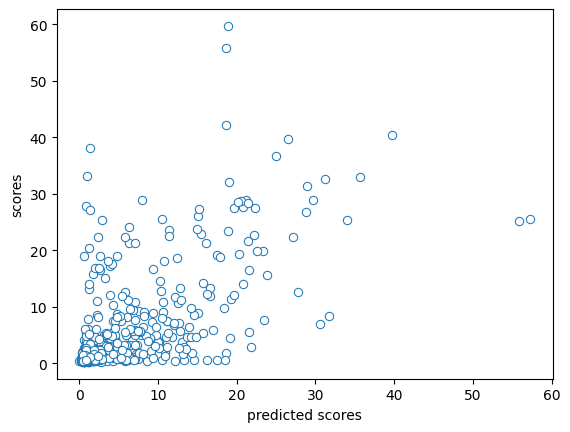

In [ ]:
import matplotlib.pyplot as plt

plt.plot(scoreshat, scores, 'o')
plt.xlabel('predicted scores')
plt.ylabel('scores')
plt.show()

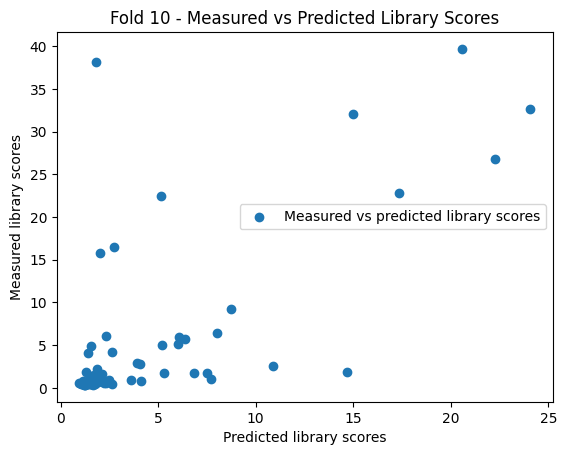



RMSE for Fold 10: 6.2761303698334485
RRMSE for Fold 10: 1.4363841539777178
R^2 for Fold 10: 0.48215053239871764


Average RMSE for all K: 5.332345735924776
Average RRMSE for all K: 1.4119129105406023
Average R^2 for all K: 0.4369885558931516




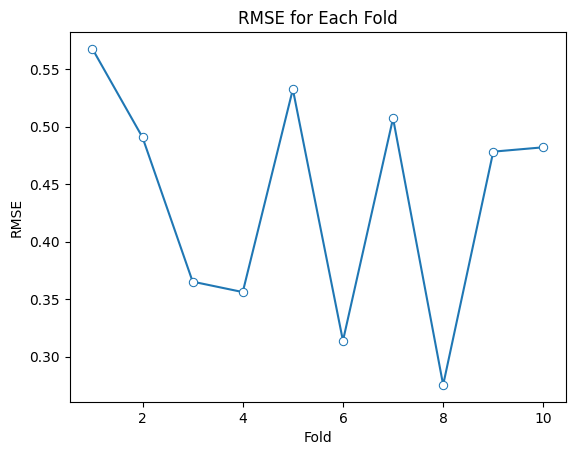

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit

# Sample data
ps = np.array(scoreshat).flatten() # probs
s = np.array(scores)   # logscores

# Define the linear regression model
def linear_model(x, a, b):
    return a * x + b

# Initial guess for the parameters
initial_guess = [1, 0]

# Number of folds for K-Fold Cross Validation
n_splits = 10

# Initialize K-Fold Cross Validation
kf = KFold(n_splits=n_splits, shuffle=True)

# List to store RMSE values for each fold
rmse_list = []
rrmse_list = []
r2_list = []

# Perform K-Fold Cross Validation
for fold, (train_index, test_index) in enumerate(kf.split(ps), start=1):
    ps_train, ps_test = ps[train_index], ps[test_index]
    s_train, s_test = s[train_index], s[test_index]

    # Fit the model
    params, covariance = curve_fit(linear_model, ps_train, s_train, p0=initial_guess)

    # Predict the log-scores on the test set
    predicted_scores = linear_model(ps_test, *params)

    # Compute the RMSE
    rmse = np.sqrt(mean_squared_error(s_test, predicted_scores))
    rmse_list.append(rmse)
    rrmse_list.append(rmse / np.average(s_test))

    # Compute the R^2 coefficient
    r2 = r2_score(s_test, predicted_scores)
    r2_list.append(r2)

    # Plot results for the last fold
    if fold == n_splits:
        plt.scatter(predicted_scores, s_test, label='Measured vs predicted library scores')
        #plt.scatter(ps_test, predicted_scores, label='Predicted Logscores', color='red')
        plt.xlabel('Predicted library scores')
        plt.ylabel('Measured library scores')
        plt.legend()
        plt.title(f'Fold {fold} - Measured vs Predicted Library Scores')
        plt.show()

print("\n")
# Print RMSE for the last fold
print(f'RMSE for Fold {n_splits}: {rmse_list[n_splits-1]}')
print(f'RRMSE for Fold {n_splits}: {rrmse_list[n_splits-1]}')
print(f'R^2 for Fold {n_splits}: {r2_list[n_splits-1]}')
print("\n")
print(f'Average RMSE for all K: {np.average(rmse_list)}')
print(f'Average RRMSE for all K: {np.average(rrmse_list)}')
print(f'Average R^2 for all K: {np.average(r2_list)}')
print("\n")

# Plot RMSE for all folds
plt.plot(range(1, n_splits + 1), r2_list, marker='o')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE for Each Fold')
plt.show()


## B-cell antigen DB

In [ ]:
import pandas as pd

amino_acid_map = {
    "Ala": "A", "Cys": "C", "Asp": "D", "Glu": "E", "Phe": "F", "Gly": "G",
    "His": "H", "Ile": "I", "Lys": "K", "Leu": "L", "Met": "M", "Asn": "N",
    "Pro": "P", "Gln": "Q", "Arg": "R", "Ser": "S", "Thr": "T", "Val": "V",
    "Trp": "W", "Tyr": "Y"
}

def apply_mutation(mutation):

    original_aa = mutation[2:5]
    position = int(mutation[5:-3]) - 1
    new_aa = mutation[-3:]

    original_aa_one_letter = amino_acid_map.get(original_aa)
    new_aa_one_letter = amino_acid_map.get(new_aa)

    if ref_seq[position] != original_aa_one_letter:
        raise ValueError(f"Original amino acid at position {position + 1} is not {original_aa_one_letter}.")
    if(new_aa_one_letter is None):
      return ref_seq[0:position]
    if(position == 0):
      mutated_seq = new_aa_one_letter + ref_seq[1:]
    elif(position == len(ref_seq) - 1):
      mutated_seq = ref_seq[:-1] + new_aa_one_letter
    else:
      mutated_seq = ref_seq[0:position] + new_aa_one_letter + ref_seq[position + 1:]

    return mutated_seq

ref_seq = 'ENLWTTASTFIVLFLLSLFYSTTVTLFKVK'
df = pd.read_csv('/content/urn_mavedb_00001202-a-1_scores.csv')

df['sequence'] = df['hgvs_pro'].apply(apply_mutation)

In [ ]:
df.to_csv("bcell_tm_library.csv")